In [28]:
import numpy as np
from scipy.optimize import linear_sum_assignment 
import matplotlib.pyplot as plt 
from scipy.spatial import Delaunay
from scipy.spatial.distance import pdist, squareform
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
import pandas as pd
rng = np.random.default_rng(0)

# Step 1 : Role Assignment and Role-Adjacency Matrix Construction

In [2]:
def simulate_swap(T=300, sigma=0.5):
    # 6-role formation
    mu = np.array([
        [-8,  2], [-2, 2], [4, 2],
        [-4, -2], [2, -2],
        [0, -6]
    ])

    N = len(mu)
    X = np.zeros((T, N, 2))

    # players assigned fixed roles initially
    roles = np.arange(N)

    # choose two roles to swap
    k1, k2 = 3, 4

    for t in range(T):
        alpha = 0
        if T//3 <= t <= 2*T//3:
            alpha = (t - T//3) / (T//3)

        for i in range(N):
            k = roles[i]
            center = mu[k]

            # interpolate swap
            if k == k1:
                center = (1-alpha)*mu[k1] + alpha*mu[k2]
            if k == k2:
                center = (1-alpha)*mu[k2] + alpha*mu[k1]

            X[t, i] = center + sigma * rng.standard_normal(2)

    return X, mu

def em_hungarian(X, n_iter=20):
    T, N, _ = X.shape

    # init role means as mean of each player trajectory
    mu = X.mean(axis=0).copy()  # (N, 2)
    Sigma = np.array([np.eye(2) for _ in range(N)])

    assignments = np.zeros((T, N), dtype=int)

    for it in range(n_iter):
        # E-step: Hungarian per frame
        for t in range(T):
            cost = np.zeros((N, N))
            for i in range(N):
                for k in range(N):
                    diff = X[t, i] - mu[k]
                    cost[i, k] = diff @ diff  # squared distance
            row_ind, col_ind = linear_sum_assignment(cost)
            # row_ind should be [0..N-1] in order, but be safe
            assignments[t, row_ind] = col_ind

        # M-step: update mu
        for k in range(N):
            mask = assignments == k
            pts = X[mask]
            if len(pts) == 0:
                continue
            mu[k] = pts.mean(axis=0)

    return mu, assignments

In [3]:
# ----- Run experiment -----
X, mu_true = simulate_swap()
mu_est, roles_est = em_hungarian(X)

In [4]:
plot = False
if plot:
    colors = plt.cm.tab10(np.arange(6))
    fig, axs = plt.subplots(1, 2, figsize=(10,4))
    # Panel A: player ID coloring
    for i in range(6):
        axs[0].plot(X[:,i,0], X[:,i,1], color=colors[i], linewidth=1)
    axs[0].set_title("Trajectories colored by PLAYER ID")
    axs[0].axis("equal")
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    # Panel B: role coloring
    for t in range(X.shape[0]):
        for i in range(6):
            k = roles_est[t,i]
            axs[1].scatter(X[t,i,0], X[t,i,1],
                        color=colors[k], s=3)

    axs[1].set_title("Same data colored by ROLE (EM+Hungarian)")
    axs[1].axis("equal")
    axs[1].set_xticks([])
    axs[1].set_yticks([])

    plt.tight_layout()


# Step 2 : Delanay Triangulation


In [5]:
def delaunay_adjacency(points):
    """
    Build symmetric adjacency matrix from Delaunay triangulation.
    """
    tri = Delaunay(points)
    N = len(points)
    A = np.zeros((N, N), dtype=int)

    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i+1, 3):
                u, v = simplex[i], simplex[j]
                A[u, v] = 1
                A[v, u] = 1

    return A

In [6]:
F442 = np.array([
    (-40,  20), (-40,   7), (-40,  -7), (-40, -20),   # Defenders (4)
    (-10,  20), (-10,   7), (-10,  -7), (-10, -20),   # Midfield (4)
    ( 25,   8), ( 25,  -8)                            # Forwards (2)
])
F343 = np.array([
    (-40,  10), (-40,   0), (-40, -10),               # Defenders (3)
    (-10,  20), (-10,   7), (-10,  -7), (-10, -20),   # Midfield (4)
    ( 25,  18), ( 25,   0), ( 25, -18)                # Forwards (3)
])
def simulate_roles(F1, F2, T=400, cp=200, sigma=2.0):
    """
    Simulates role trajectories with a single formation change.
    """
    N = len(F1)
    V = np.zeros((T, N, 2))

    for t in range(T):
        mu = F1 if t < cp else F2
        V[t] = mu + sigma * np.random.randn(N,2)

    return V

In [7]:
V = simulate_roles(F442,F343)
A = np.array([delaunay_adjacency(V[t]) for t in range(len(V))])

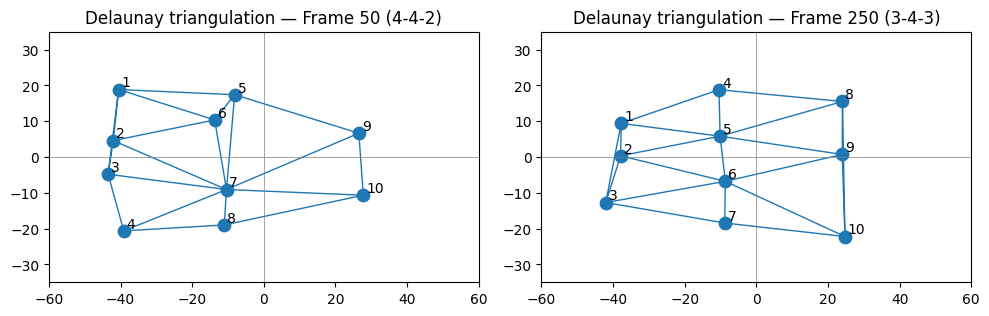

In [8]:
def plot_delaunay(ax, V_frame, title):
    tri = Delaunay(V_frame)
    ax.triplot(V_frame[:, 0],V_frame[:, 1],tri.simplices,lw=1)
    ax.scatter(V_frame[:, 0],V_frame[:, 1],s=80)

    for i, (x, y) in enumerate(V_frame):
        ax.text(x + 0.8, y + 0.8, str(i+1), fontsize=10)

    ax.axhline(0, color='gray', lw=0.5)
    ax.axvline(0, color='gray', lw=0.5)

    ax.set_xlim(-60, 60)
    ax.set_ylim(-35, 35)

    ax.set_aspect("equal")
    ax.set_title(title)

fig, ax = plt.subplots(1, 2, figsize=(10,4))

plot_delaunay(ax[0], V[50],  "Delaunay triangulation — Frame 50 (4-4-2)")
plot_delaunay(ax[1], V[250], "Delaunay triangulation — Frame 250 (3-4-3)")

plt.tight_layout()
plt.savefig("report/figures/delany_form_change.png", dpi=250)

In [9]:
def plot_cmap(ax, A, title, cmap="Greys"):
    im = ax.imshow(
        A,
        vmin=0,
        vmax=1,
        cmap=cmap,
        interpolation="nearest"
    )
    ax.set_title(title, fontsize=11)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    return im

A_pre_frame   = A[0]      
A_post_frame  = A[200]   
A_pre_mean  = A[:200].mean(axis=0)
A_post_mean = A[200:].mean(axis=0)


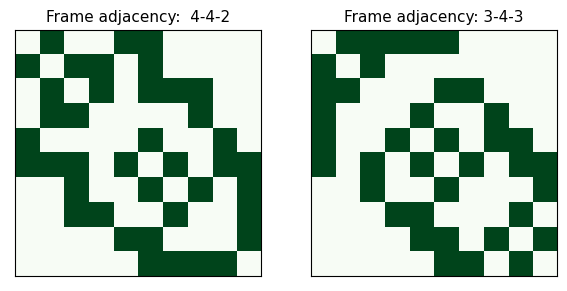

In [10]:
fig1, ax1 = plt.subplots(1, 2, figsize=(7,4))
plot_cmap(ax1[0], A[0],   "Frame adjacency:  4-4-2", cmap="Greens")
plot_cmap(ax1[1],A[200], "Frame adjacency: 3-4-3", cmap="Greens")
plt.savefig("report/figures/A_examples.png", dpi=250,bbox_inches="tight", pad_inches=0.02)

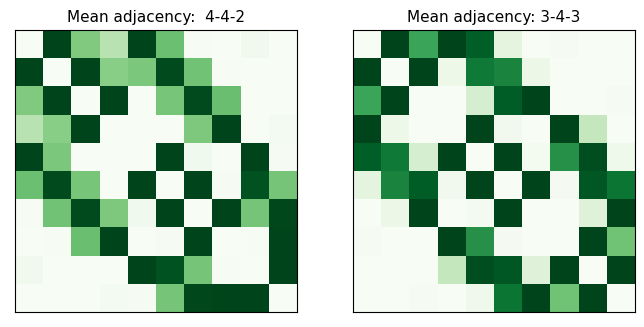

In [11]:
fig1, ax1 = plt.subplots(1, 2, figsize=(8,4))
im = plot_cmap(ax1[0], A_pre_mean,   "Mean adjacency:  4-4-2", cmap="Greens")
plot_cmap(ax1[1],A_post_mean, "Mean adjacency: 3-4-3", cmap="Greens")

plt.savefig("report/figures/A_mean.png", dpi=250,bbox_inches="tight", pad_inches=0.02)

## Discrete G-Segmentation

In [ ]:
numpy2ri.activate()
gSeg = importr("gSeg")

def manhattan_matrix_distance(A, B):
    """Manhattan distance between two (10x10) adjacency matrices."""
    return np.abs(A - B).sum()

def mean_matrix(A):
    """Mean adjacency matrix over a segment."""
    return A.mean(axis=0)

def build_r_graph_from_matrices(A):
    """
    Prepare all R-side inputs from matrix sequence A.

    Parameters
    ----------
    A : ndarray (T, 10, 10)
    
    Returns
    -------
    X_uni : ndarray (U,100)   unique flattened matrices
    id_vec : ndarray (T,)     mapping frames -> unique nodes (1-based)
    """
    T = A.shape[0]
    X = A.reshape(T, -1)

    # handle repeated observations
    X_uni, inv = np.unique(X, axis=0, return_inverse=True)
    id_vec = inv + 1  # R uses 1-based indexing

    return X_uni, id_vec

def run_gseg_discrete(X_uni, id_vec):
    """
    Calls R gseg1_discrete on a segment and returns CP candidates.

    Returns dictionary:
      {stat_name: (tau, pval)}
    """
    ro.globalenv["dat_uni"] = X_uni
    ro.globalenv["id"] = id_vec

    ro.r("""
    dmat <- dist(dat_uni)
    E <- gSeg::nnl(dmat, 1)

    res <- gSeg::gseg1_discrete(
        n = length(id),
        E = E,
        id = id,
        statistics = "all"
    )
    """)

    # ----------- Extract statistics -----------------
    stats = {}
    families = ["ori", "weighted", "generalized", "max.type"]
    variants = ["a", "u"]
    name_map = {
        "ori": "Original",
        "weighted": "Weighted",
        "generalized": "Generalized",
        "max.type": "Max"
    }
    for fam in families:
        for var in variants:
            label = f"{name_map[fam]}_{var}"

            tau = int(ro.r(f"res$scanZ${fam}$tauhat_{var}")[0])
            p   = float(ro.r(f"res$pval.appr${fam}_{var}")[0])

            stats[label] = {
                "tau": tau,
                "pval": p
            }

    return stats
def is_significant_cp(A_seg, tau,
                      pval,
                      fps,
                      alpha=0.01,
                      min_minutes=5,
                      min_dist=7.0):
    """
    Determines if a CP satisfies ALL paper constraints.
    """

    # --- criterion 1: statistical
    if pval >= alpha:
        return False

    # --- criterion 2: duration
    min_frames = int(min_minutes * 60 * fps)

    if min(tau, A_seg.shape[0] - tau) < min_frames:
        return False

    # --- criterion 3: matrix distance
    M1 = mean_matrix(A_seg[:tau])
    M2 = mean_matrix(A_seg[tau:])

    d = manhattan_matrix_distance(M1, M2)

    if d < min_dist:
        return False

    return True

def recursive_cp(A,
                 start_idx,
                 fps,
                 alpha,
                 min_minutes,
                 min_dist):

    results = []

    T = A.shape[0]

    min_frames = int(min_minutes * 60 * fps)

    # Too small to segment
    if T < 2 * min_frames:
        return results

    # -----------------
    # Run gseg
    # -----------------
    X_uni, id_vec = build_r_graph_from_matrices(A)
    stats = run_gseg_discrete(X_uni, id_vec)

    # -----------------
    # Select best statistic (Generalized union)
    # -----------------
    best = stats["Generalized_u"]

    tau = best["tau"]
    pval = best["pval"]

    # -----------------
    # Significance test
    # -----------------
    if not is_significant_cp(A, tau, pval,
                             fps=fps,
                             alpha=alpha,
                             min_minutes=min_minutes,
                             min_dist=min_dist):
        return results

    # Global index of CP
    global_tau = start_idx + tau

    # ------------------
    # Recursive split
    # ------------------

    results.append(global_tau)

    left  = recursive_cp(A[:tau], start_idx,
                          fps, alpha, min_minutes, min_dist)

    right = recursive_cp(A[tau:], global_tau,
                          fps, alpha, min_minutes, min_dist)

    return left + results + right


def detect_formation_changes(A,
                              fps=1,
                              alpha=0.01,
                              min_minutes=5,
                              min_dist=7.0):
    """
    Full SoccerCPD-style detection.

    Parameters
    ----------
    A : ndarray (T,10,10)
        Role adjacency matrix sequence.
    fps : float
        Sampling rate in frames/second.
    alpha : float
        Statistical threshold.
    min_minutes : int
        Minimum segment duration in minutes.
    min_dist : float
        Manhattan distance threshold between mean formations.
    Returns
    -------
    dict with:
      - 'change_points' : sorted list of indices
      - 'num_phases'    : count of segments
      - 'segments'     : list of (start, end)
    """

    cps = recursive_cp(A,
                        start_idx=0,
                        fps=fps,
                        alpha=alpha,
                        min_minutes=min_minutes,
                        min_dist=min_dist)

    cps = sorted(cps)

    segments = []
    prev = 0

    for cp in cps:
        segments.append((prev, cp))
        prev = cp

    segments.append((prev, A.shape[0]))

    return {
        "change_points": cps,
        "num_phases": len(segments),
        "segments": segments
    }


Original edge-count statistic (u): p-value approximation without skewness correction is reported.
Weighted edge-count statistic (u): p-value approximation without skewness correction is reported.
Max-type edge-count statistic (u): p-value approximation without skewness correction is reported.
Original edge-count scan statistic (a) : 
  Estimated change-point location: 200 
  Test statistic: 36.10527 
  Approximated p-value: 1.16176e-155 
Original edge-count scan statistic (u) : 
  Estimated change-point location: 200 
  Test statistic: 74.03091 
  Approximated p-value: 0 
Weighted edge-count statistic (a) : 
  Estimated change-point location: 200 
  Test statistic: 36.10527 
  Approximated p-value: 1.700885e-80 
Weighted edge-count statistic (u) : 
  Estimated change-point location: 201 
  Test statistic: 74.17608 
  Approximated p-value: 0 
Generalized edge-count statistic (a) : 
  Estimated change-point location: 200 
  Test statistic: 1345.176 
  Approximated p-value: 2.802037e-290 

In [43]:
results = detect_formation_changes(
    A,
    fps=1,
    alpha=0.01,
    min_minutes=1,
    min_dist=10
)

Original edge-count statistic (u): p-value approximation without skewness correction is reported.
Weighted edge-count statistic (u): p-value approximation without skewness correction is reported.
Max-type edge-count statistic (u): p-value approximation without skewness correction is reported.
Original edge-count scan statistic (a) : 
  Estimated change-point location: 200 
  Test statistic: 36.10527 
  Approximated p-value: 1.16176e-155 
Original edge-count scan statistic (u) : 
  Estimated change-point location: 200 
  Test statistic: 74.03091 
  Approximated p-value: 0 
Weighted edge-count statistic (a) : 
  Estimated change-point location: 200 
  Test statistic: 36.10527 
  Approximated p-value: 1.700885e-80 
Weighted edge-count statistic (u) : 
  Estimated change-point location: 201 
  Test statistic: 74.17608 
  Approximated p-value: 0 
Generalized edge-count statistic (a) : 
  Estimated change-point location: 200 
  Test statistic: 1345.176 
  Approximated p-value: 2.802037e-290 

In [44]:
results

{'change_points': [201], 'num_phases': 2, 'segments': [(0, 201), (201, 400)]}